## Business Problem 
<p>To make the trip on Boston Airbnb more meanigful, I will use machine learning solutions and data visualization techniques to analyze three factors - </p>
<ul>
    <li><b>Location:</b> What regions do you have more choice or you are more likely to stay in Boston Airbnb?</li>
    <li><b>Room Type:</b> What types of rooms are most popular for stay?</li>
    <li><b>Price:</b> What are the important features to influence price? Could you predict the price of Boston Airbnb?</li>
</ul>
<p>by reviewing data from 25 neighborhoods across Boston Airbnb.</p>

### Prepare Data

#### Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import math
import seaborn as sns
from scipy.stats import kde

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
import warnings
#Suppress Warning
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

from sklearn.linear_model import Lasso

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer, r2_score
from sklearn.metrics import mean_absolute_error

import shap
shap.initjs()

#### Load the boston airbnb data

In [5]:
boston_airbnb_df = pd.read_csv('listings.csv')
boston_airbnb_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,3781,HARBORSIDE-Walk to subway,4804,Frank,NaN,East Boston,42.36413,-71.02991,Entire home/apt,125,28,16,2019-12-21,0.27,1,97
1,5506,**$49 Special ** Private! Minutes to center!,8229,Terry,NaN,Roxbury,42.32981,-71.09559,Entire home/apt,145,3,107,2020-05-01,0.78,6,333
2,6695,$99 Special!! Home Away! Condo,8229,Terry,NaN,Roxbury,42.32994,-71.09351,Entire home/apt,169,3,115,2019-11-02,0.87,6,317
3,8789,Curved Glass Studio/1bd facing Park,26988,Anne,NaN,Downtown,42.35919,-71.06265,Entire home/apt,99,91,25,2020-04-15,0.35,8,365
4,10730,Bright 1bed facing Golden Dome,26988,Anne,NaN,Downtown,42.35840,-71.06185,Entire home/apt,150,91,32,2020-04-16,0.25,8,282


### Data Understanding
<p>The dataset has been derived from Inside Airbnb, and it consists of 3440 listings, 16 features of Airbnb across Boston neighborhoods.</p>

In [6]:
boston_airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3440 entries, 0 to 3439
Data columns (total 16 columns):
id                                3440 non-null int64
name                              3440 non-null object
host_id                           3440 non-null int64
host_name                         3436 non-null object
neighbourhood_group               0 non-null float64
neighbourhood                     3440 non-null object
latitude                          3440 non-null float64
longitude                         3440 non-null float64
room_type                         3440 non-null object
price                             3440 non-null int64
minimum_nights                    3440 non-null int64
number_of_reviews                 3440 non-null int64
last_review                       2711 non-null object
reviews_per_month                 2711 non-null float64
calculated_host_listings_count    3440 non-null int64
availability_365                  3440 non-null int64
dtypes: float64(4),

#### Droping columns not needed for analysis

In [8]:
boston_airbnb_df = boston_airbnb_df.drop(columns=['id', 'name', 'host_name', 'neighbourhood_group', 'last_review'])
boston_airbnb_df.head()

,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,4804,East Boston,42.36413,-71.02991,Entire home/apt,125,28,16,0.27,1,97
1,8229,Roxbury,42.32981,-71.09559,Entire home/apt,145,3,107,0.78,6,333
2,8229,Roxbury,42.32994,-71.09351,Entire home/apt,169,3,115,0.87,6,317
3,26988,Downtown,42.35919,-71.06265,Entire home/apt,99,91,25,0.35,8,365
4,26988,Downtown,42.35840,-71.06185,Entire home/apt,150,91,32,0.25,8,282


#### Handle missing data

In [9]:
boston_airbnb_df.isnull().sum()

host_id                             0
neighbourhood                       0
latitude                            0
longitude                           0
room_type                           0
price                               0
minimum_nights                      0
number_of_reviews                   0
reviews_per_month                 729
calculated_host_listings_count      0
availability_365                    0
dtype: int64

#### Proportion of reviews_per_month that are not nulls

In [10]:
len(boston_airbnb_df['reviews_per_month'].dropna()) / len(boston_airbnb_df)

0.7880813953488373

#### Only keep numerical variables for data imputation

In [11]:
boston_airbnb_df_num = boston_airbnb_df.select_dtypes(include=['float64', 'int64'])
boston_airbnb_df_num.head()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,4804,42.36413,-71.02991,125,28,16,0.27,1,97
1,8229,42.32981,-71.09559,145,3,107,0.78,6,333
2,8229,42.32994,-71.09351,169,3,115,0.87,6,317
3,26988,42.35919,-71.06265,99,91,25,0.35,8,365
4,26988,42.35840,-71.06185,150,91,32,0.25,8,282


#### Mean Function - one of the methods to handle missing values to fill them with average of the column.

In [13]:
# The column reviews_per_month has about 21 % of the data 
# is missing. In order to proceed further and avoid skewed 
# results, we will use the fillna with mean.
fill_mean = lambda col: col.fillna(col.mean())
fill_df = boston_airbnb_df_num.apply(fill_mean, axis=0)
fill_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3440 entries, 0 to 3439
Data columns (total 9 columns):
host_id                           3440 non-null int64
latitude                          3440 non-null float64
longitude                         3440 non-null float64
price                             3440 non-null int64
minimum_nights                    3440 non-null int64
number_of_reviews                 3440 non-null int64
reviews_per_month                 3440 non-null float64
calculated_host_listings_count    3440 non-null int64
availability_365                  3440 non-null int64
dtypes: float64(3), int64(6)
memory usage: 242.0 KB


### Data Visualization

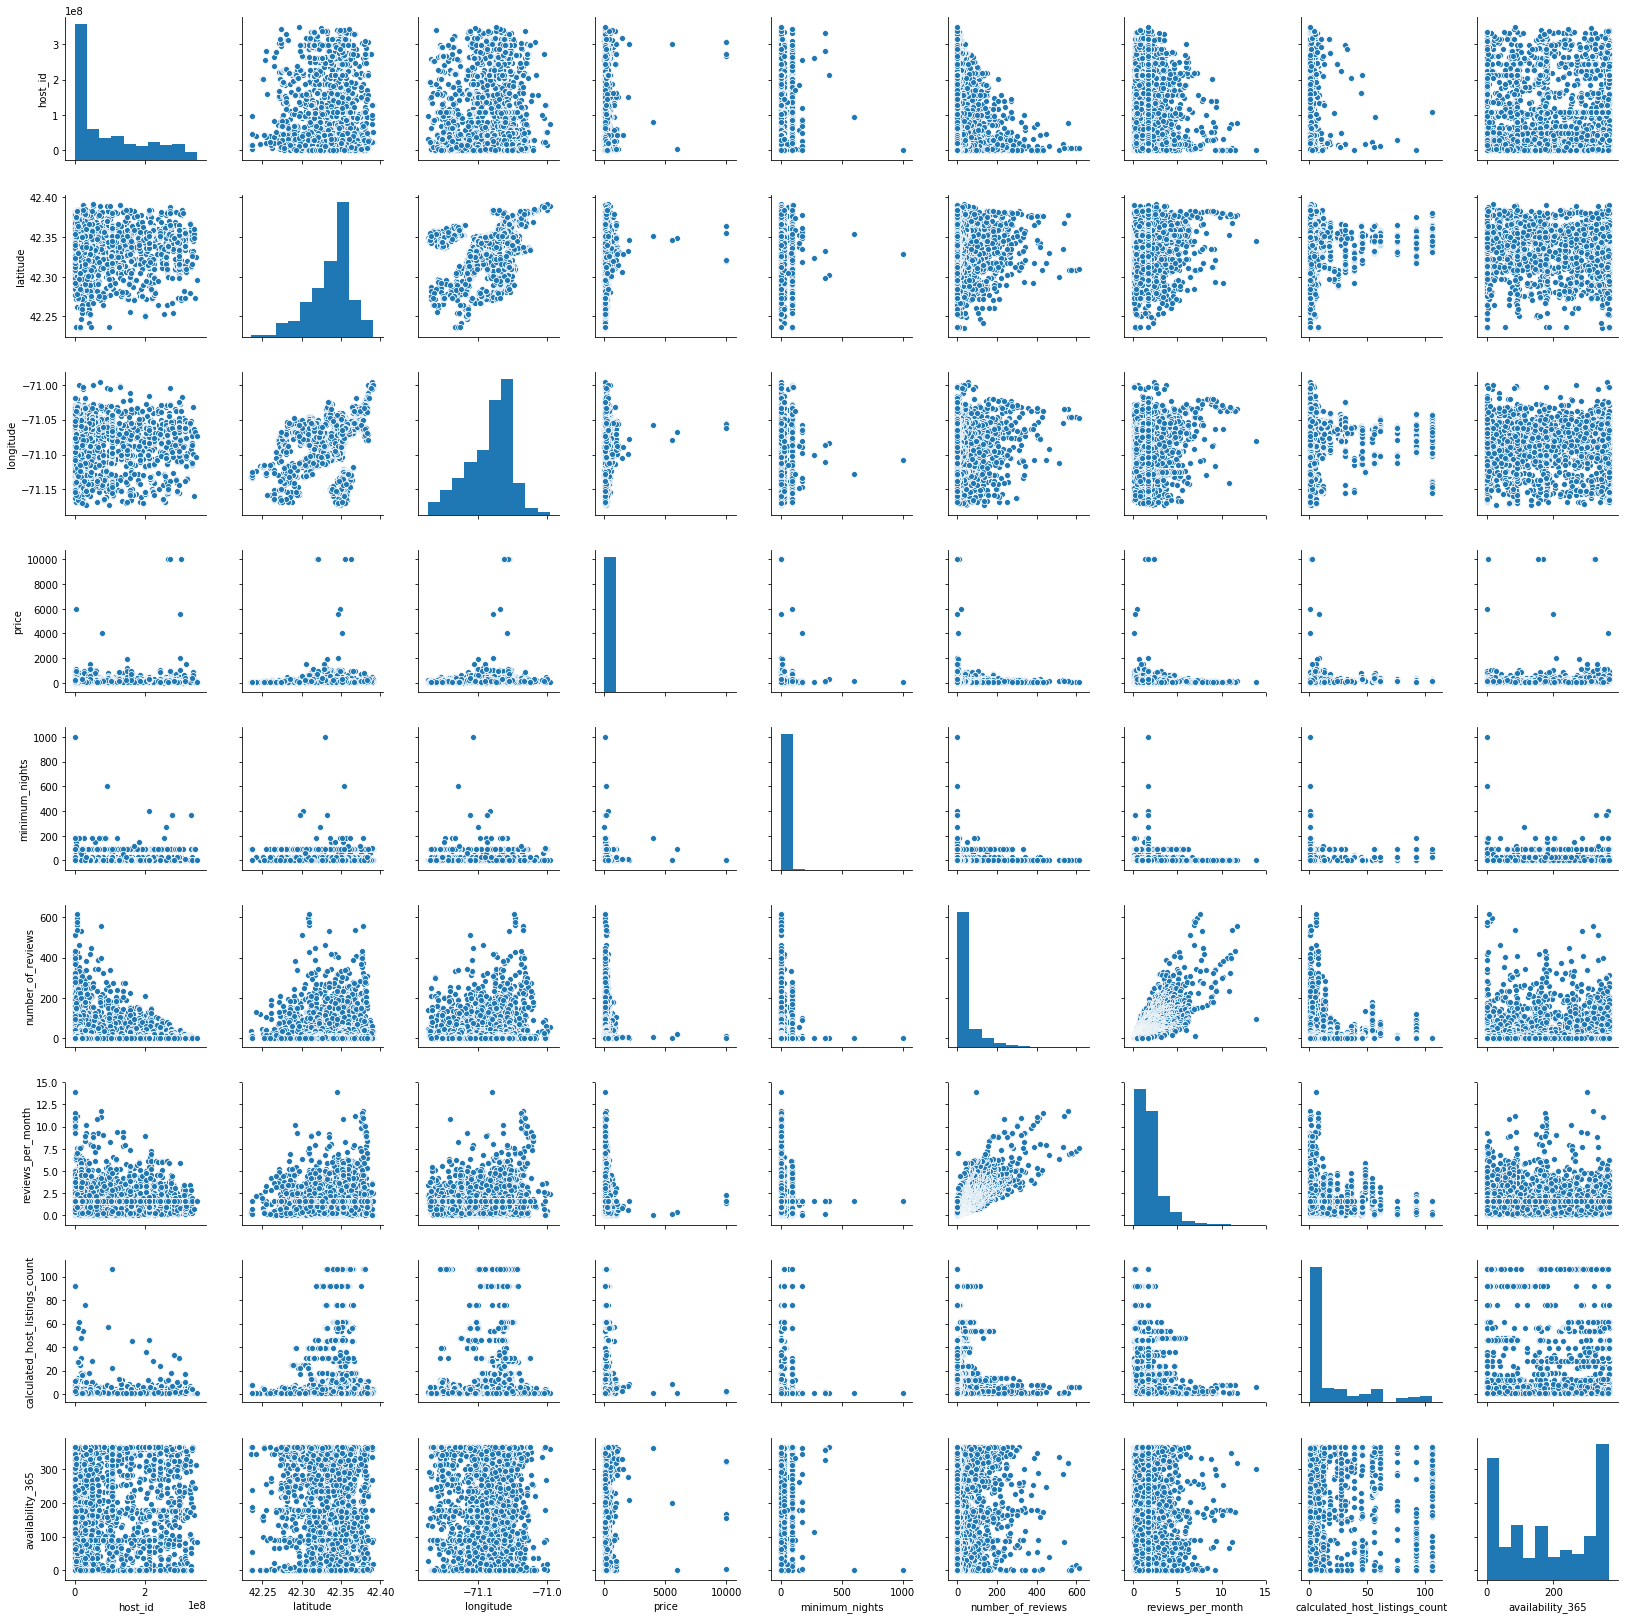

In [14]:
sns.pairplot(fill_df)

<p>Insights from the above plot - </p>
<ul>
    <li>Latitude: From South 42.25 to North 42.40, the number of listings are increasing.</li>
    <li>Longitude: From West -71.15 to East -71.00, the number of listings for Boston Airbnb increases.</li>
    <li> The Number_of_Reviews and Reviews_Per_Month are positively correlated.</li>
</ul>

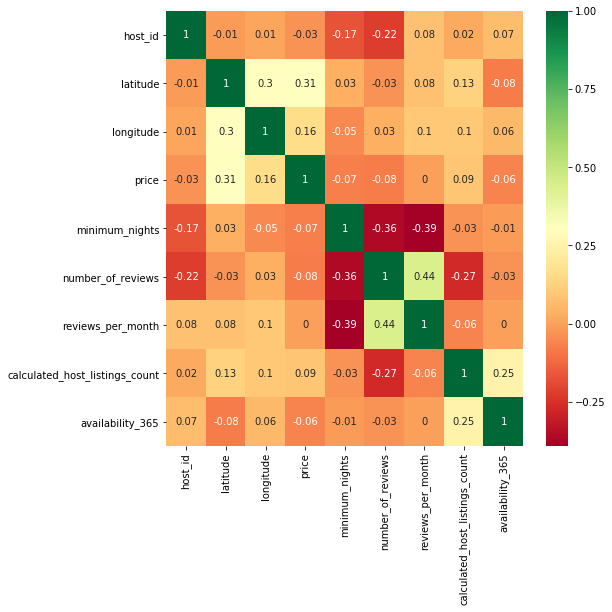

In [17]:
plt.figure(figsize=(8,8))
corr = fill_df.corr(method='spearman')
sns.heatmap(round(corr,2), annot=True,cmap="RdYlGn")
plt.show()

<p>Insights from above plot - </p>
<ul>
    <li>Latitude is positively correlated with price(r=0.31) and longitude(r=0.30).</li>
    <li>The number of reviews and review per month are positively correlated(r=0.44).</li>
    <li> Availability 365 and calculated host listings count are positively correlated(r=0.25).</li>
</ul>

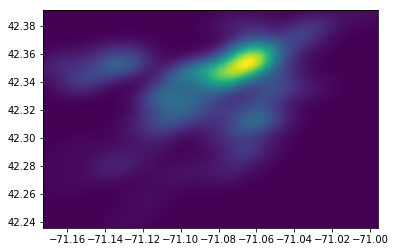

In [18]:
x = boston_airbnb_df['longitude']
y = boston_airbnb_df['latitude']

# Evaluate a gaussian kde on a regular grid of nbins X 
# nbins over data extents
nbins=300
k = kde.gaussian_kde([x, y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
plt.show()

In [20]:
boston_airbnb_df['neighbourhood'].value_counts()

Dorchester                 422
Downtown                   277
Jamaica Plain              260
Roxbury                    256
Back Bay                   224
South End                  214
Brighton                   203
Allston                    197
South Boston               168
Fenway                     167
East Boston                157
Mission Hill               129
Beacon Hill                129
Chinatown                   93
Charlestown                 84
North End                   76
Roslindale                  69
Bay Village                 68
West End                    55
South Boston Waterfront     55
Mattapan                    49
Hyde Park                   42
West Roxbury                37
Longwood Medical Area        6
Leather District             3
Name: neighbourhood, dtype: int64

Text(0.5, 0, 'Neighbourhoods')

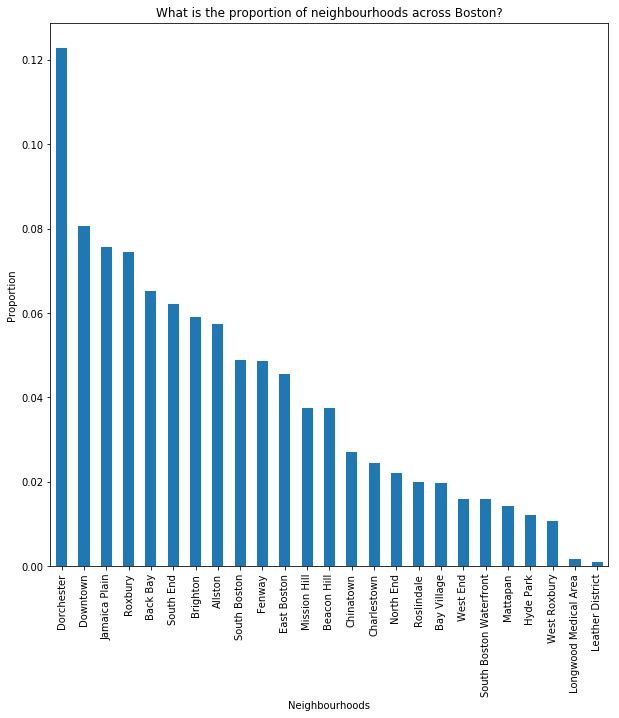

In [22]:
neighbourhood_values = boston_airbnb_df.neighbourhood.value_counts()
plt.figure(figsize=(10,10))
(neighbourhood_values/boston_airbnb_df.shape[0]).plot(kind="bar")
plt.title("What is the proportion of neighbourhoods across Boston?")
plt.ylabel('Proportion')
plt.xlabel('Neighbourhoods')

<p>Dorchester has an easily higher proportion of Airbnb compared to other neighborhoods, at 12 %.</p>

Text(41.21428955555555, 0.5, 'latitude')

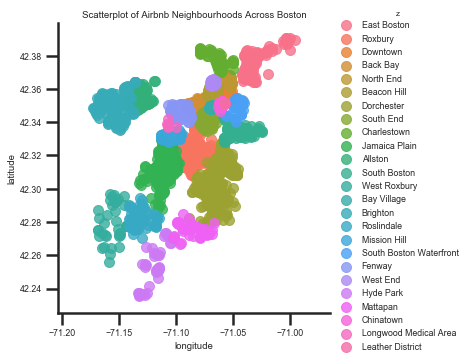

In [27]:
boston_airbnb_df['x'] = boston_airbnb_df['longitude']
boston_airbnb_df['y'] = boston_airbnb_df['latitude']
boston_airbnb_df['z'] = boston_airbnb_df['neighbourhood']

sns.set_context("poster", font_scale=0.4)
sns.set_style("ticks")

sns.lmplot('x', # Horizontal axis
           'y', # Vertical axis
           data=boston_airbnb_df, # Data source
           fit_reg=False, # Don't fix a regression line
           hue="z", # Set color
           scatter_kws={"marker": "D", # Set marker style
                        "s": 100}) # S marker size

plt.title('Scatterplot of Airbnb Neighbourhoods Across Boston')

plt.xlabel('longitude')

plt.ylabel('latitude')

Text(34.04141316666667, 0.5, 'latitude')

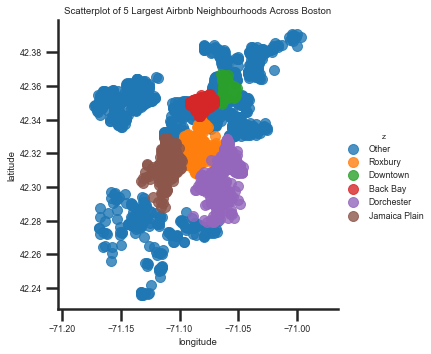

In [26]:
neighborhoods = ['Dorchester', 'Downtown', 'Jamaica Plain',
                 'Roxbury', 'Back Bay' ]

boston_airbnb_df['x'] = boston_airbnb_df['longitude']
boston_airbnb_df['y'] = boston_airbnb_df['latitude']
#list comprehension to compare regions in neighborhoods to other
boston_airbnb_df['z'] = [x if x in neighborhoods else 'Other' for x in boston_airbnb_df['neighbourhood']]

sns.set_context("poster", font_scale=0.4)
sns.set_style("ticks")

sns.lmplot('x', # Horizontal axis
           'y', # Vertical axis
           data=boston_airbnb_df, # Data source
           fit_reg=False, # Don't fix a regression line
           hue="z", # Set color
           scatter_kws={"marker": "D", # Set marker style
                        "s": 100}) # S marker size

plt.title('Scatterplot of 5 Largest Airbnb Neighbourhoods Across Boston')
# plt.legend(['Dorchester', 'Downtown', 'Chinatown', 'Brighton'], loc='right')

plt.xlabel('longitude')

plt.ylabel('latitude')

In [28]:
boston_airbnb_df['room_type'].value_counts()

Entire home/apt    2128
Private room       1270
Hotel room           26
Shared room          16
Name: room_type, dtype: int64

In [29]:
fill_df['minimum_nights'].value_counts().head(20)

91     845
1      740
2      613
28     234
30     220
3      211
32     142
29     101
9       67
31      62
10      39
4       35
5       25
7       21
20      13
180     12
14       8
60       6
90       6
92       6
Name: minimum_nights, dtype: int64

In [30]:
fill_df['number_of_reviews'].value_counts().head(20)

0     729
1     267
2     134
3     115
4      90
5      80
7      69
6      67
8      60
9      52
11     46
10     42
13     38
14     38
12     36
18     35
15     33
31     27
17     27
43     26
Name: number_of_reviews, dtype: int64

In [31]:
fill_df['reviews_per_month'].value_counts().sort_values(ascending=False).head(20)

1.654935    729
0.040000     35
0.090000     31
0.020000     30
0.060000     30
0.140000     29
0.080000     29
0.050000     28
0.130000     27
0.170000     26
0.100000     26
0.160000     26
0.150000     25
0.200000     23
1.000000     22
0.070000     21
0.300000     21
0.030000     20
0.290000     20
0.260000     19
Name: reviews_per_month, dtype: int64

In [32]:
fill_df['availability_365'].value_counts().head(20)

0      576
365    345
364    107
90     105
180     61
344     42
179     37
325     35
80      35
363     35
160     31
243     30
362     27
313     23
89      23
361     22
270     22
282     21
88      20
360     20
Name: availability_365, dtype: int64

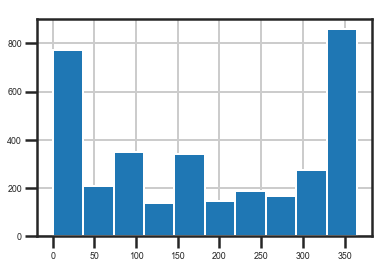

In [33]:
fill_df['availability_365'].hist()

#### Average minimum nights by room types

In [34]:
boston_airbnb_df.groupby(['room_type'])['minimum_nights'].mean().sort_values(ascending=False)

room_type
Shared room        40.687500
Private room       34.527559
Entire home/apt    31.822368
Hotel room          1.000000
Name: minimum_nights, dtype: float64

#### Average number of reviews by room type

In [35]:
boston_airbnb_df.groupby(['room_type'])['number_of_reviews'].mean().sort_values(ascending=False)

room_type
Private room       43.004724
Entire home/apt    40.181391
Shared room        24.187500
Hotel room         14.730769
Name: number_of_reviews, dtype: float64

#### Average reviews per month by room type

In [36]:
boston_airbnb_df.groupby(['room_type'])['reviews_per_month'].mean().sort_values(ascending=False)

room_type
Entire home/apt    1.670233
Private room       1.639601
Shared room        1.365833
Hotel room         1.341176
Name: reviews_per_month, dtype: float64

In [37]:
fill_df2 = fill_df.join(boston_airbnb_df['room_type'])
fill_df2.head()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type
0,4804,42.36413,-71.02991,125,28,16,0.27,1,97,Entire home/apt
1,8229,42.32981,-71.09559,145,3,107,0.78,6,333,Entire home/apt
2,8229,42.32994,-71.09351,169,3,115,0.87,6,317,Entire home/apt
3,26988,42.35919,-71.06265,99,91,25,0.35,8,365,Entire home/apt
4,26988,42.35840,-71.06185,150,91,32,0.25,8,282,Entire home/apt


#### Average days of availability by room type

In [39]:
fill_df2.groupby(['room_type'])['availability_365'].mean().sort_values(ascending=False)

room_type
Hotel room         207.500000
Private room       194.045669
Entire home/apt    178.318609
Shared room        131.937500
Name: availability_365, dtype: float64

### What are the important features to predict price? Could you predict the price of Boston Airbnb?

In [40]:
# Categorical variables like room_type is correlated to
# price, which is non-numerical and need to be converted 
fill_df2 = pd.get_dummies(fill_df2, columns=['room_type'])
fill_df2.head()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,4804,42.36413,-71.02991,125,28,16,0.27,1,97,1,0,0,0
1,8229,42.32981,-71.09559,145,3,107,0.78,6,333,1,0,0,0
2,8229,42.32994,-71.09351,169,3,115,0.87,6,317,1,0,0,0
3,26988,42.35919,-71.06265,99,91,25,0.35,8,365,1,0,0,0
4,26988,42.35840,-71.06185,150,91,32,0.25,8,282,1,0,0,0


In [41]:
fill_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3440 entries, 0 to 3439
Data columns (total 13 columns):
host_id                           3440 non-null int64
latitude                          3440 non-null float64
longitude                         3440 non-null float64
price                             3440 non-null int64
minimum_nights                    3440 non-null int64
number_of_reviews                 3440 non-null int64
reviews_per_month                 3440 non-null float64
calculated_host_listings_count    3440 non-null int64
availability_365                  3440 non-null int64
room_type_Entire home/apt         3440 non-null uint8
room_type_Hotel room              3440 non-null uint8
room_type_Private room            3440 non-null uint8
room_type_Shared room             3440 non-null uint8
dtypes: float64(3), int64(6), uint8(4)
memory usage: 255.4 KB


#### Detect any outliers at column 'price'

In [42]:
boston_airbnb_df['price'].describe(percentiles=[0.97])

count     3440.000000
mean       181.736337
std        428.723906
min          0.000000
50%        130.000000
97%        500.000000
max      10000.000000
Name: price, dtype: float64

#### Create new dataset filtering prices of Boston Airbnb that are above 500

In [43]:
fill_df2 = fill_df2[fill_df2['price']<=500]
fill_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3357 entries, 0 to 3439
Data columns (total 13 columns):
host_id                           3357 non-null int64
latitude                          3357 non-null float64
longitude                         3357 non-null float64
price                             3357 non-null int64
minimum_nights                    3357 non-null int64
number_of_reviews                 3357 non-null int64
reviews_per_month                 3357 non-null float64
calculated_host_listings_count    3357 non-null int64
availability_365                  3357 non-null int64
room_type_Entire home/apt         3357 non-null uint8
room_type_Hotel room              3357 non-null uint8
room_type_Private room            3357 non-null uint8
room_type_Shared room             3357 non-null uint8
dtypes: float64(3), int64(6), uint8(4)
memory usage: 275.4 KB


#### Review room type in original dataset

In [45]:
boston_airbnb_df['room_type'].value_counts().sort_values(ascending=False)

Entire home/apt    2128
Private room       1270
Hotel room           26
Shared room          16
Name: room_type, dtype: int64

#### Proportion of Hotel & Shared Room

In [46]:
len(boston_airbnb_df[boston_airbnb_df['room_type'] == 'Hotel room'])/len(boston_airbnb_df) + len(boston_airbnb_df[boston_airbnb_df['room_type'] == 'Shared room'])/len(boston_airbnb_df)

0.012209302325581395

#### Drop binary columns 'room_type_Hotel room', 'room_type_Shared room', because they consist about just 1 percent of data

In [47]:
fill_df2 = fill_df2.drop(axis=1, columns=['room_type_Hotel room', 'room_type_Shared room'])

In [48]:
fill_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3357 entries, 0 to 3439
Data columns (total 11 columns):
host_id                           3357 non-null int64
latitude                          3357 non-null float64
longitude                         3357 non-null float64
price                             3357 non-null int64
minimum_nights                    3357 non-null int64
number_of_reviews                 3357 non-null int64
reviews_per_month                 3357 non-null float64
calculated_host_listings_count    3357 non-null int64
availability_365                  3357 non-null int64
room_type_Entire home/apt         3357 non-null uint8
room_type_Private room            3357 non-null uint8
dtypes: float64(3), int64(6), uint8(2)
memory usage: 268.8 KB


In [49]:
fill_df2.head()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Entire home/apt,room_type_Private room
0,4804,42.36413,-71.02991,125,28,16,0.27,1,97,1,0
1,8229,42.32981,-71.09559,145,3,107,0.78,6,333,1,0
2,8229,42.32994,-71.09351,169,3,115,0.87,6,317,1,0
3,26988,42.35919,-71.06265,99,91,25,0.35,8,365,1,0
4,26988,42.35840,-71.06185,150,91,32,0.25,8,282,1,0


#### Review spearman correlation heatmap on 11 features

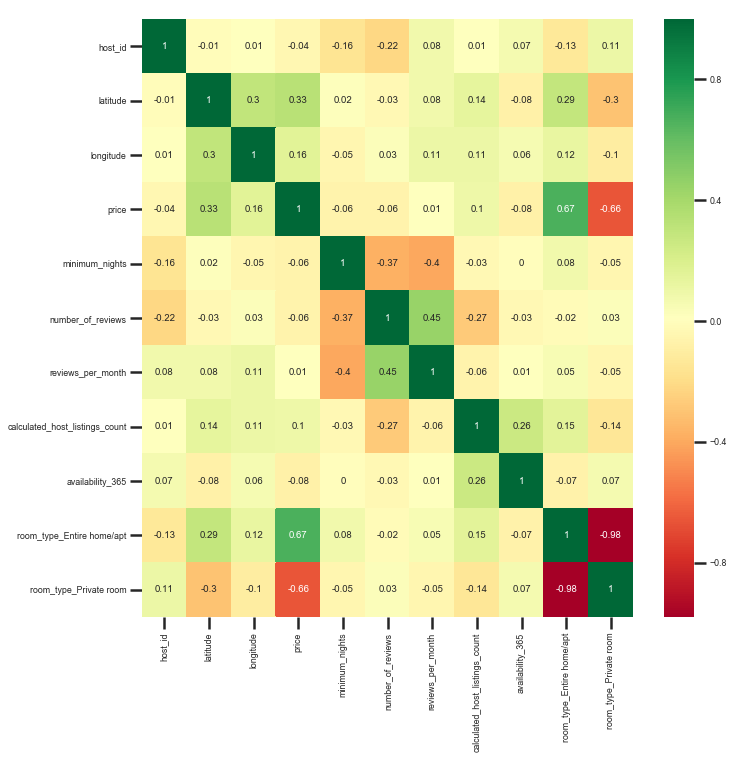

In [51]:
plt.figure(figsize=(11,11))
corr = fill_df2.corr(method='spearman')
sns.heatmap(round(corr, 2), annot=True, cmap="RdYlGn")
plt.show()

<p> Insights from above plot - </p>
<ul>
    <li>Price and Home Type: Entire home/apt is positively correlated to price(r=0.67). The private room is negatively correlated to price(r=0.66). the average price for Entire home/apt is higher tha the average price for the private room.</li>
    <li>Latitude is positively correlated to price. As latitude increases from south to north, the rpices of Airbnb may tend to increase.</li>
    <li>The number of reviews and reviews per month are positvely correlated.</li>
    <li>The number of reviews and reviews per month is negatively correlated to minimum nights.</li>
</ul>

In [53]:
print('Average Price by Private Room:', fill_df2.groupby(['room_type_Private room'])['price'].mean().sort_values(ascending=False)[1], 'U.S.Dollars')

Average Price by Private Room: 81.22406967537609 U.S.Dollars


In [54]:
print('Average Price by Entire Home or Apartment:', fill_df2.groupby(['room_type_Entire home/apt'])['price'].mean().sort_values(ascending=False)[1],'U.S.Dollars')

Average Price by Entire Home or Apartment: 189.38394160583942 U.S.Dollars


## Data Modeling

#### Split into explanatory & response variables

In [55]:
X = fill_df2.drop(axis=1, columns=['price'])
y = fill_df2['price']
y.head()

0    125
1    145
2    169
3     99
4    150
Name: price, dtype: int64

#### Split dataset into train and test

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
y_test.head()

3333     45
606     219
3232     76
1079    125
322     100
Name: price, dtype: int64

#### Linear Regression Model

In [58]:
# Instantiate the model
linear_regression_model = LinearRegression(normalize=True)
# Fit the model
linear_regression_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [59]:
# View the intercept
linear_regression_model.intercept_

-9110.242879174666

In [60]:
# View the feature coefficients
linear_regression_model.coef_

array([ 4.14607210e-08,  5.04652813e+02,  1.70549092e+02, -2.31547968e-01,
       -6.92339491e-03, -6.33925777e+00, -2.61881533e-01, -6.85061296e-03,
        7.63758859e+01, -2.71616675e+01])

In [61]:
# Predict using your model
y_pred = linear_regression_model.predict(X_test)

def custom_metric(y_test, y_pred):
    '''
        Create custom metric that returns r-squared score
        
        Params:
        y_test - target values
        y_pred - estimated target values
        
        Returns: A regression score generally btw 0-1.
        Note - It is a diff btw target values & estimated 
        target values
    '''
    r2 = r2_score(y_test, y_pred)            
    return r2

In [62]:
# Make scorer and definethat higher scores are better
score = make_scorer(custom_metric, greater_is_better=True)

In [63]:
# Apply custom score to linear regression : r-squared score
score(linear_regression_model, X_test, y_test)

0.3409897398167825

In [67]:
def custom_metric(y_test, y_pred):
    '''
        Create custom metric that returns average of absolute error score
        
        Params:
        y_test - target values
        y_pred - estimated target values
        
        Returns: A non-negative floating point
        Note - best value is 0.0
    '''
    mae = mean_absolute_error(y_test, y_pred)
    return mae

In [68]:
# Make scorer and define that higher scores are better
score = make_scorer(custom_metric, greater_is_better=True)

In [69]:
# Apply custom score to linear regression : absolute error score
score(linear_regression_model, X_test, y_test)

55.05467900470752

#### Lasso Model

In [70]:
# Instantiate and normalize inside teh model
lasso_model = Lasso(alpha=0.1, normalize=True, random_state=42)
# Fit the model
lasso_model = lasso_model.fit(X_train, y_train)

In [71]:
# Predict using your model
y_pred = lasso_model.predict(X_test)

def custom_metric(y_test, y_pred):
    '''
        Create custom metric that returns r-squared score
        
        Params:
        y_test - target values
        y_pred - estimated target values
        
        Returns: A regression score generally btw 0-1.
        Note - It is a diff btw target values & estimated 
        target values
    '''
    r2 = r2_score(y_test, y_pred)            
    return r2

In [72]:
# Make scorer and define that higher scores are better
score = make_scorer(custom_metric, greater_is_better=True)

In [74]:
# Apply custom score to lasso : r-squared score
score(lasso_model, X_test, y_test)

0.31032609710323755

In [75]:
# Check the weights of the feature
coef = pd.Series(lasso_model.coef_, index = X.columns)
coef.sort_values(ascending=False)

latitude                          335.928547
room_type_Entire home/apt          58.840388
longitude                          32.522254
availability_365                   -0.000000
calculated_host_listings_count     -0.000000
number_of_reviews                  -0.000000
host_id                             0.000000
minimum_nights                     -0.067112
reviews_per_month                  -0.645478
room_type_Private room            -32.270076
dtype: float64

In [76]:
def custom_metric(y_test, y_pred):
    '''
        Create custom metric that returns average of absolute error score
        
        Params:
        y_test - target values
        y_pred - estimated target values
        
        Returns: A non-negative floating point
        Note - best value is 0.0
    '''
    mae = mean_absolute_error(y_test, y_pred)
    return mae

In [77]:
# Make scorer and define that higher scores are better
score = make_scorer(custom_metric, greater_is_better=True)

In [78]:
# Apply custom score to lasso : absolute error score
score(lasso_model, X_test, y_test)

56.16783363099204

#### Random Forest Model

In [79]:
# Create decision tree classifier object
random_forest_model = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=1000)
# Train model
random_forest_model = random_forest_model.fit(X_train, y_train)

In [80]:
# Predict using your model
y_pred = random_forest_model.predict(X_test)

# Create custom metric
def custom_metric(y_test, y_pred):
    '''
        Create custom metric that returns r-squared score
        
        Params:
        y_test - target values
        y_pred - estimated target values
        
        Returns: A regression score generally btw 0-1.
        Note - It is a diff btw target values & estimated 
        target values
    '''
    r2 = r2_score(y_test, y_pred)            
    return r2

In [81]:
# Make scorer and define that higher scores are better
score = make_scorer(custom_metric, greater_is_better=True)

In [82]:
# Apply custom score to random forest : r-squared score
score(random_forest_model, X_test, y_test)

0.5490835716120421

In [83]:
def custom_metric(y_test, y_pred):
    '''
        Create custom metric that returns average of absolute error score
        
        Params:
        y_test - target values
        y_pred - estimated target values
        
        Returns: A non-negative floating point
        Note - best value is 0.0
    '''
    mae = mean_absolute_error(y_test, y_pred)
    return mae

In [84]:
# Make scorer and define that higher scores are better
score = make_scorer(custom_metric, greater_is_better=True)

In [85]:
# Apply custom score to random forest : absolute error score
score(random_forest_model, X_test, y_test)

40.42255402317177

In [86]:
import scipy.stats
scipy.stats.spearmanr(y_test, y_pred)

SpearmanrResult(correlation=0.8277913334850704, pvalue=2.4795066260935694e-170)

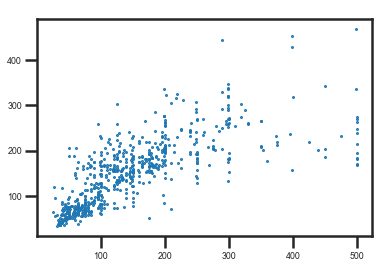

In [87]:
plt.scatter(y_test, y_pred, 1)

#### Check the average price in test & predicted datasets for Boston Airbnb 

In [88]:
y.mean(), y_pred.mean()

(147.846291331546, 149.52805842368195)

#### Sort feature importance in Random Forest Regression Model

In [89]:
feature_importances = list(zip(random_forest_model.feature_importances_, X.columns))
feature_importances.sort(reverse=True)

#### Visualize the feature importance

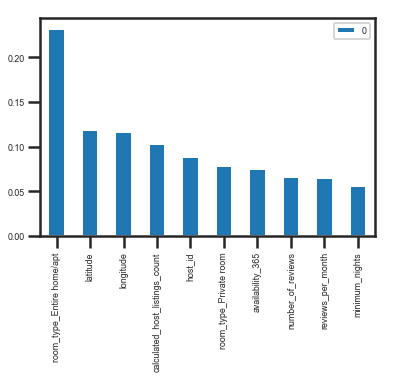

In [90]:
pd.DataFrame(feature_importances, index=[x for (_,x) in feature_importances]).plot(kind='bar')

#### Explain output of model by Shapley Value

In [91]:
random_forest_model_shap_values = shap.TreeExplainer(random_forest_model)
shap_values = random_forest_model_shap_values.shap_values(X_test)

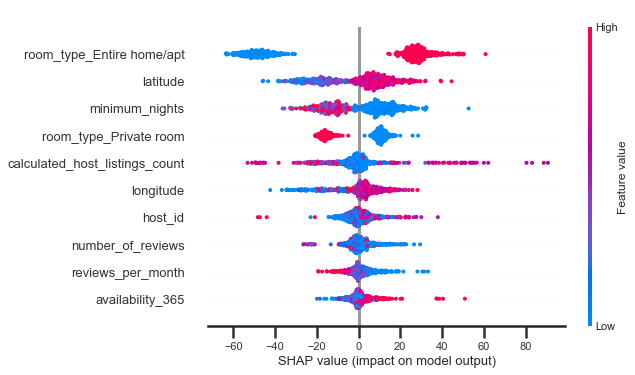

In [93]:
shap.summary_plot(shap_values, X_test)

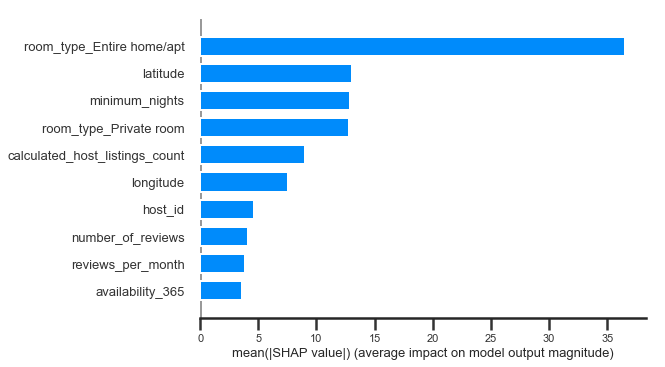

In [94]:
shap.summary_plot(shap_values, X_test, plot_type="bar")